In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys
import os
import random
import gc
import subprocess
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.style.use('./stylelib/custom.mplstyle')

%load_ext autoreload
%autoreload 2
import preprocessing
import plotter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## 1. Data Preprocessing
### 1.1 Downsample training data
Only 1% of the all training records is used for exploratory data analysis

In [3]:
%%time

dir_data = './data'
from_scratch = True

csv_raw = os.path.join(dir_data, 'train.csv')
csv_reduced = os.path.join(dir_data, 'train_sample.csv')
if from_scratch:
    nlines_raw, nlines_reduced = preprocessing.csv_randomized_downsamp(
        csv_in=csv_raw, csv_out=csv_reduced, fraction=0.001
    )

CPU times: user 7.26 ms, sys: 10.3 ms, total: 17.6 ms
Wall time: 3min 39s


### 1.2 Load into data frame and inspect raw features

In [4]:
# Load sampled csv into pandas dataframe, sort by click time (and reset index)
df = pd.read_csv(
    csv_reduced, parse_dates=['click_time', 'attributed_time']
).sort_values(by='click_time').reset_index()

# Inspect first few lines
display(df.head(3))

,index,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,28325,107922,3,1,19,379,2017-11-06 15:58:34,NaT,0
1,97574,109644,18,1,19,121,2017-11-06 16:00:01,NaT,0
2,39474,12788,15,1,15,315,2017-11-06 16:00:02,NaT,0


### 1.3 Time feature construction
* Convert UTC time to Asia/Shanghai time
* Extract hour of the day from `click_time` as a separate feature `click_hour` 

In [5]:
# Convert UTC to local time
for col in ['click_time', 'attributed_time']:
    df[col] = pd.DatetimeIndex(df[col]).tz_localize('utc').tz_convert('Asia/Shanghai')

# Extract hour of the day
df['click_hour'] = df['click_time'].dt.hour

### 1.4 Feature engineering
Construct feature combinations, and use the counts of records belonging to each of the combinations as the new features.

In [6]:
# Generate feature combinations
feature_primary = 'ip'
feature_other = ['click_hour', 'os', 'device', 'channel', 'app']
feature_combinations = preprocessing.list_feature_combinations(
    feature_primary=feature_primary, feature_other=feature_other
)

In [7]:
# Load engineered features into dataframe
csv_engineered = os.path.join(dir_data, 'train_sample_engineered.csv')
if not os.path.exists(csv_engineered):
    df_engineered = preprocessing.df_engineered(
        df_in=df, feature_combinations=feature_combinations, csv_out=csv_engineered
    )
else:
    df_engineered = pd.read_csv(csv_engineered)
df_engineered.drop(columns=['index'], inplace=True)
display(df_engineered.head(3))

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_hour,count_ip_click_hour,...,count_ip_os_device_channel,count_ip_os_device_app,count_ip_os_channel_app,count_ip_device_channel_app,count_ip_click_hour_os_device_channel,count_ip_click_hour_os_device_app,count_ip_click_hour_os_channel_app,count_ip_click_hour_device_channel_app,count_ip_os_device_channel_app,count_ip_click_hour_os_device_channel_app
0,107922,3,1,19,379,2017-11-06 23:58:34+08:00,NaT,0,23,2,...,1,1,1,1,1,1,1,1,1,1
1,109644,18,1,19,121,2017-11-07 00:00:01+08:00,NaT,0,0,2,...,1,2,1,2,1,2,1,1,1,1
2,12788,15,1,15,315,2017-11-07 00:00:02+08:00,NaT,0,0,3,...,1,2,1,2,1,2,1,1,1,1


---
## 2. Exploratory data analysis

(1) Train-test split

In [8]:
df_train, df_test = train_test_split(df_engineered, test_size=0.2, random_state=42)

(2) Visualize click count as function of click time

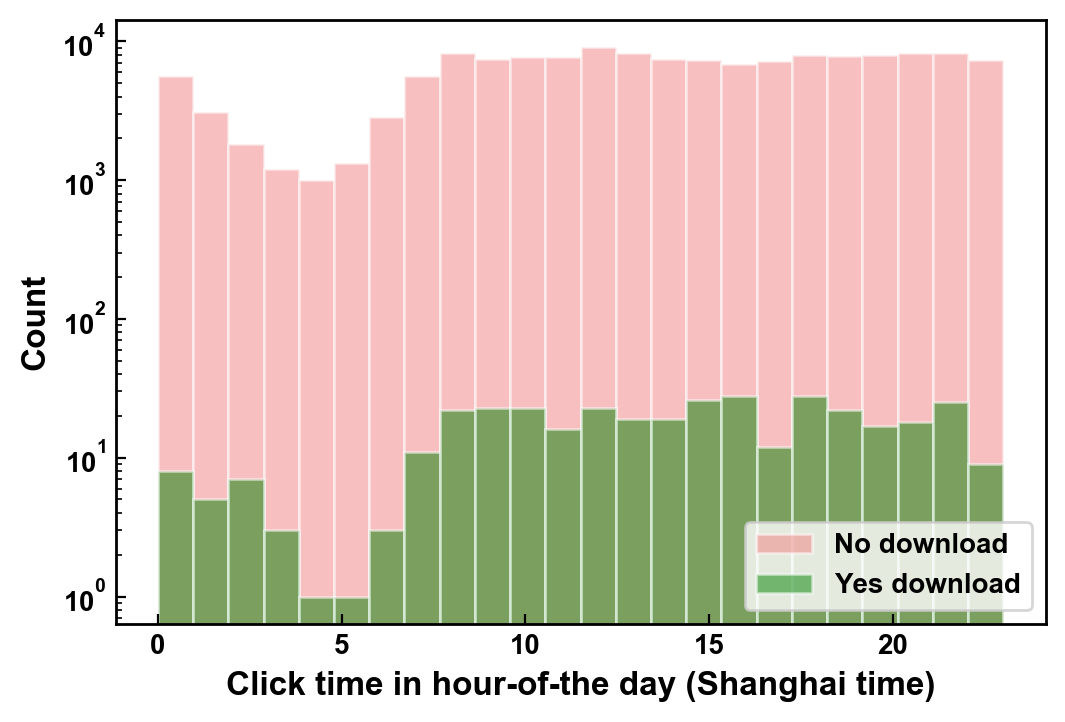

In [9]:
hist_params = dict(bins=24, edgecolor='w', alpha=0.5)
fig, ax = plt.subplots()
ax = plotter.compare_hist(df_train, by='click_hour', hist_params=hist_params, ax=ax)
ax.set(xlabel='Click time in hour-of-the day (Shanghai time)')
plt.show();

---
## 3. Machine learning

In [60]:
cols = [x for x in df_train.columns if 'count' in x] + ['app', 'device', 'os', 'click_hour', 'channel']
X_train, y_train = (df_train[cols], df_train['is_attributed'])
X_test, y_test = (df_test[cols], df_test['is_attributed'])

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (cross_val_score, RandomizedSearchCV)

In [62]:
model = DecisionTreeClassifier(class_weight='balanced')
#model = DecisionTreeClassifier()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.6294724361097394


In [45]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

0.5


/Users/shandou/anaconda3/envs/mlnd_capstone/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
from sklearn.feature_selection import RFE
estimator = DecisionTreeClassifier()
selector = RFE(estimator, step=1)
selector = selector.fit(X_train, y_train)

In [36]:
selector

RFE(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
  n_features_to_select=None, step=1, verbose=0)

In [37]:
print(selector.support_)
print(selector.ranking_)

[ True  True  True False  True  True  True False False  True  True  True
  True  True  True False False False False  True False False  True False
  True False False False False False False]
[ 1  1  1  9  1  1  1 11  2  1  1  1  1  1  1  5 15 16  8  1 10  7  1  4
  1 17 12 14  6  3 13]


In [38]:
col_array = np.array(cols)
col_array

array(['count_ip_click_hour', 'count_ip_os', 'count_ip_device',
       'count_ip_channel', 'count_ip_app', 'count_ip_click_hour_os',
       'count_ip_click_hour_device', 'count_ip_click_hour_channel',
       'count_ip_click_hour_app', 'count_ip_os_device',
       'count_ip_os_channel', 'count_ip_os_app',
       'count_ip_device_channel', 'count_ip_device_app',
       'count_ip_channel_app', 'count_ip_click_hour_os_device',
       'count_ip_click_hour_os_channel', 'count_ip_click_hour_os_app',
       'count_ip_click_hour_device_channel',
       'count_ip_click_hour_device_app',
       'count_ip_click_hour_channel_app', 'count_ip_os_device_channel',
       'count_ip_os_device_app', 'count_ip_os_channel_app',
       'count_ip_device_channel_app',
       'count_ip_click_hour_os_device_channel',
       'count_ip_click_hour_os_device_app',
       'count_ip_click_hour_os_channel_app',
       'count_ip_click_hour_device_channel_app',
       'count_ip_os_device_channel_app',
       'count_ip_cl

In [39]:
cols = col_array[selector.support_]

In [40]:
X_train, y_train = (df_train[cols], df_train['is_attributed'])
X_test, y_test = (df_test[cols], df_test['is_attributed'])

In [41]:
model = DecisionTreeClassifier()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
auc = roc_auc_score(y_test, y_pred)
print(auc)

X_train.shape

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.4983734988750034


(147922, 15)